In [1]:
from UTILITY_quickstart import *

from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy as np
from UTILITY_setLattice import setLattice, getBendkG, getQuadkG, getSextkG, setBendkG, setQuadkG, setSextkG, setXOffset, setYOffset


In [2]:
importedDefaultSettings = loadConfig("setLattice_configs/defaults.yml")

tao = initializeTao(
    loadDefaultLatticeTF = False
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Not using setLattice(). Golden lattice
WARNING! No beam file is specified!
Number of macro particles defined by input file
Beam created, written to /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/beams/activeBeamFile.h5, and reinit to tao


## Golden lattice

In [3]:
setLattice(tao, **importedDefaultSettings)
launchTwissCorrection(tao)


tao.ele_twiss( "PR15944" )

No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [0.13000809 0.88704422 0.36260991 1.98836191]
Objective Function Value at Optimal Parameters: 4.614255455486702e-09
Number of Iterations: 94
Converged: True


{'mode_flip': False,
 'beta_a': 9.71608398680662,
 'alpha_a': -0.430254012171645,
 'gamma_a': 0.121974914646586,
 'phi_a': 36.8207831507441,
 'eta_a': -1.268155264235e-05,
 'etap_a': -5.27344477090706e-07,
 'beta_b': 44.4514789365882,
 'alpha_b': 1.73028815066635,
 'gamma_b': 0.0898484635355742,
 'phi_b': 34.2332594545917,
 'eta_b': 1.95668377320768e-18,
 'etap_b': -6.03044987968167e-20,
 'eta_x': -1.268155264235e-05,
 'etap_x': -5.27344477090706e-07,
 'eta_y': 1.95660906990666e-18,
 'etap_y': -6.0304202326369e-20}

In [4]:
tao.ele_twiss( "TCY15280" )

{'mode_flip': False,
 'beta_a': 17.7233930225775,
 'alpha_a': 0.615938959266996,
 'gamma_a': 0.0778282578164205,
 'phi_a': 34.0328134770581,
 'eta_a': 1.46282193546108e-05,
 'etap_a': -8.37881100431517e-07,
 'beta_b': 154.039600925105,
 'alpha_b': -8.47768881950062,
 'gamma_b': 0.473068011619402,
 'phi_b': 31.8284832115546,
 'eta_b': -3.29061414703777e-18,
 'etap_b': -1.72295776954661e-19,
 'eta_x': 1.46282193546108e-05,
 'etap_x': -8.37881100431517e-07,
 'eta_y': -3.29037618425968e-18,
 'etap_y': -1.72282265974413e-19}

In [5]:
getMatrix(tao, "TCY15280", "PR15944", print = True );

-0.493357,4.177589,-0.000000,0.000000,0.000000,0.000000
-0.086586,-0.979785,-0.000000,-0.000000,0.000000,0.000000
-0.000000,-0.000000,-3.178847,51.114148,0.000000,0.000000
0.000000,0.000000,0.186026,-3.257050,-0.000000,-0.000000
0.000000,-0.000000,-0.000000,0.000000,1.000000,0.000001
0.000000,-0.000000,-0.000000,0.000000,0.000000,0.845106


In [6]:
#Note that, since TCAV3 streaks in y not x, this is changed from phi_a to phi_b
tao.ele_twiss( "PR15944" )["phi_b"] - tao.ele_twiss( "TCY15280" )["phi_b"]

2.4047762430371016

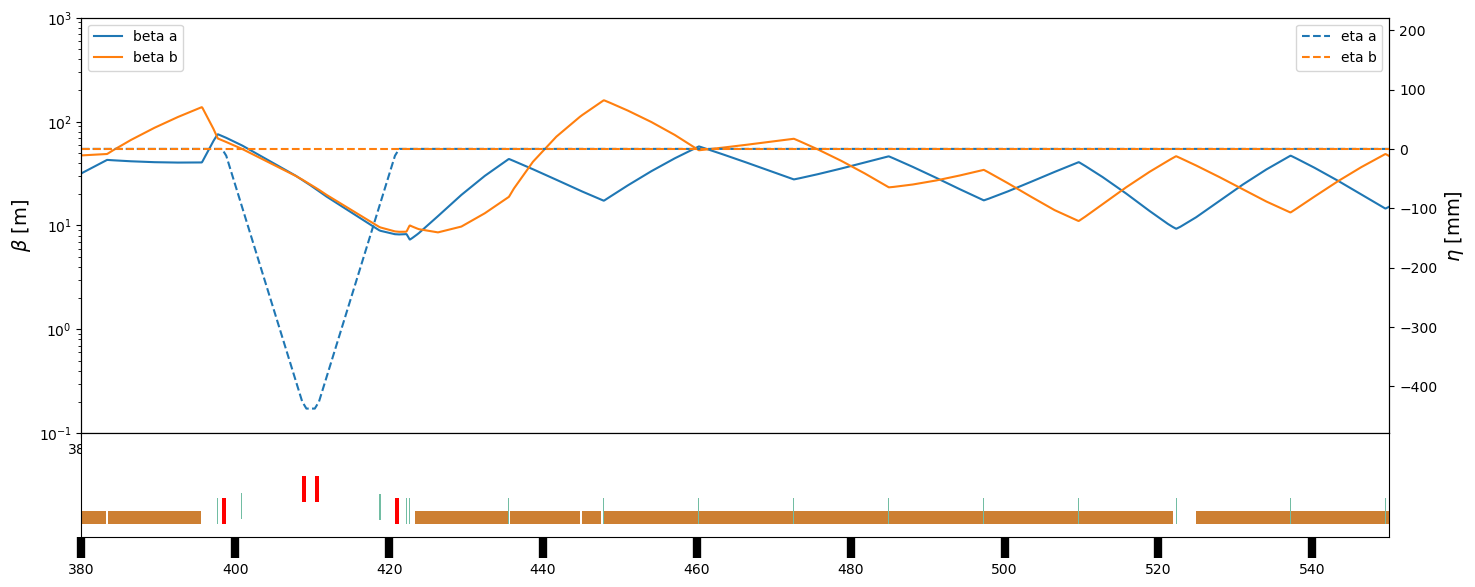

In [7]:
floorplanPlot(tao, zmin = 380, zmax = 550, ymin = 0.1, ymax = 1000)

In [8]:
def calculateYResolution(tao, verbose = False):
    betaY = tao.ele_twiss( "TCY15280" )["beta_b"]
    deltaPhi = tao.ele_twiss( "PR15944" )["phi_b"] - tao.ele_twiss( "TCY15280" )["phi_b"]
    resolution = 1 / ( np.sqrt(betaY) * np.abs( np.sin( deltaPhi ) ) )
    
    if verbose:
        print( betaY, deltaPhi, resolution ) 

    return resolution

In [9]:
calculateYResolution(tao, verbose = True)

154.039600925105 2.4047762430371016 0.11991057959780331


0.11991057959780331

## Optimization: EPICS quads only

In [10]:
print( getQuadkG(tao, "QM14891") ) #BCON = 24.5
print( getQuadkG(tao, "Q14901") ) #BCON = -31.3

24.80557735831561
-31.313860349735613


In [11]:
def objective( params, tao ):
    QM14891kG, Q14901kG = params
    
    try:
        #Prevent recalculation until changes are made
        tao.cmd("set global lattice_calc_on = F")
        
        setQuadkG(tao, "QM14891", QM14891kG)
        setQuadkG(tao, "Q14901", Q14901kG)
        
        #Reenable lattice calculations
        tao.cmd("set global lattice_calc_on = T")
    
    except: #If Bmad doesn't like the proposed solution, don't crash, give a bad number
        return 1e20

    yResolution = calculateYResolution(tao)
    #print( yResolution )

    return yResolution




quadNameList = ["QM14891", "Q14901"] 
initialGuess = [getQuadkG(tao, name) for name in quadNameList]
#initialGuess = [30, -30]

#For now, just hardcoding bounds... could generalize if required

bounds = [(0, 62), (-62, 0)]


# Perform optimization using Nelder-Mead
# result = minimize(
#     objective, 
#     initialGuess, 
#     method='Nelder-Mead',
#     bounds = bounds,
#     args = (tao, )
# )

result = differential_evolution(
    objective, 
    bounds = bounds,
    args = (tao, ),
    #maxiter = 50,
    polish = False,
    disp = True
)


print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")



differential_evolution step 1: f(x)= 0.07512516747452509
differential_evolution step 2: f(x)= 0.07512516747452509
differential_evolution step 3: f(x)= 0.07512516747452509
differential_evolution step 4: f(x)= 0.07512516747452509
differential_evolution step 5: f(x)= 0.07512516747452509
differential_evolution step 6: f(x)= 0.07512516747452509
differential_evolution step 7: f(x)= 0.07512516747452509
differential_evolution step 8: f(x)= 0.07512516747452509
differential_evolution step 9: f(x)= 0.07495582126279263
differential_evolution step 10: f(x)= 0.07495582126279263
differential_evolution step 11: f(x)= 0.07495582126279263
differential_evolution step 12: f(x)= 0.07495582126279263
differential_evolution step 13: f(x)= 0.07495582126279263
differential_evolution step 14: f(x)= 0.07495582126279263
Optimization Results:
Optimal Parameters: [ 40.80876221 -61.99352234]
Objective Function Value at Optimal Parameters: 0.07495582126279263
Number of Iterations: 14
Converged: True


In [12]:
objective( result.x, tao )
calculateYResolution(tao, verbose = True)

305.580860477753 2.2733601047996004 0.07495582126279263


0.07495582126279263

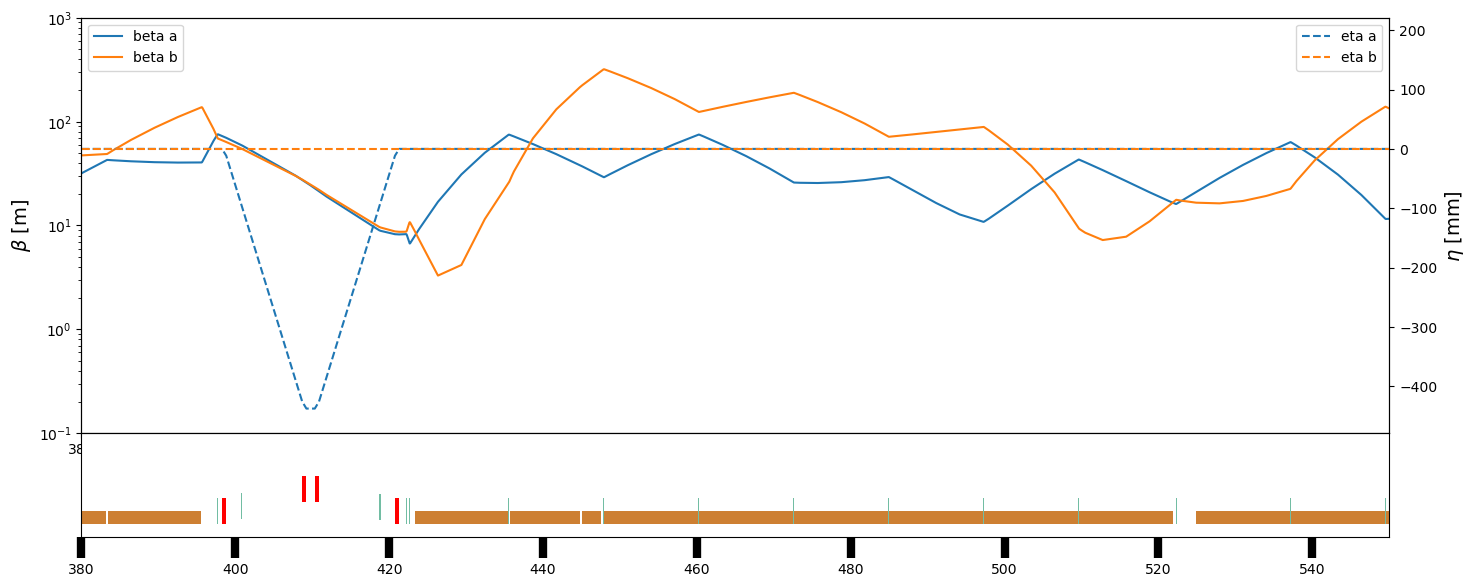

In [13]:
floorplanPlot(tao, zmin = 380, zmax = 550, ymin = 0.1, ymax = 1000)

## Optimization: 10% trim on string quads

In [14]:
tao.ele_head("PR15944")["s"]

522.843669853449

In [15]:
tao.ele_head("Q15901")["s"]

522.343669853449

In [16]:
print( getQuadkG(tao, "Q15201") ) #BACT = 14.5
print( getQuadkG(tao, "Q15301") ) #BACT = -14.1
print( getQuadkG(tao, "Q15401") ) #BACT = 11.3
print( getQuadkG(tao, "Q15501") ) #BACT = -8.2
print( getQuadkG(tao, "Q15601") ) #BACT = 10.6
print( getQuadkG(tao, "Q15701") ) #BACT = -12.5
print( getQuadkG(tao, "Q15801") ) #BACT = 15.9
print( getQuadkG(tao, "Q15901") ) #BACT = -16.1

14.134497395663042
-14.110884172759905
11.08266849604572
-7.966686036148234
10.117530736492498
-11.849268079345993
15.45245008700142
-16.049020775046326


In [17]:
def objective( params, tao ):
    QM14891kG, Q14901kG, Q15201kG, Q15301kG, Q15401kG, Q15501kG, Q15601kG, Q15701kG, Q15801kG, Q15901kG  = params
    
    try:
        #Prevent recalculation until changes are made
        tao.cmd("set global lattice_calc_on = F")
        
        setQuadkG(tao, "QM14891", QM14891kG)
        setQuadkG(tao, "Q14901", Q14901kG)
        
        setQuadkG(tao, "Q15201", Q15201kG)
        setQuadkG(tao, "Q15301", Q15301kG)
        setQuadkG(tao, "Q15401", Q15401kG)
        setQuadkG(tao, "Q15501", Q15501kG)
        setQuadkG(tao, "Q15601", Q15601kG)
        setQuadkG(tao, "Q15701", Q15701kG)
        setQuadkG(tao, "Q15801", Q15801kG)
        setQuadkG(tao, "Q15901", Q15901kG)
        
        #Reenable lattice calculations
        tao.cmd("set global lattice_calc_on = T")
    
    except: #If Bmad doesn't like the proposed solution, don't crash, give a bad number
        return 1e20

    yResolution = calculateYResolution(tao)
    #print( yResolution )

    return yResolution




quadNameList = [
    "QM14891",
    "Q14901",
    
    "Q15201",
    "Q15301",
    "Q15401",
    "Q15501",
    "Q15601",
    "Q15701",
    "Q15801",
    "Q15901",
] 
initialGuess = [getQuadkG(tao, name) for name in quadNameList]

#HARDCODE WARNING: Put EPICS quads back to their original settings
initialGuess[0] = 24.80557735831561
initialGuess[1] = -31.313860349735613



#10% range
bounds = [ sorted( [ 0.9 * getQuadkG(tao, name), 1.1 * getQuadkG(tao, name) ] ) for name in quadNameList ]


#Override for EPICS quads; they get their whole range
bounds[0] = [0, 62]
bounds[1] = [-62, 0]


# Perform optimization using Nelder-Mead
result = minimize(
    objective, 
    initialGuess, 
    method='Nelder-Mead',
    bounds = bounds,
    args = (tao, )
)

# result = differential_evolution(
#     objective, 
#     bounds = bounds,
#     args = (tao, ),
#     #maxiter = 50,
#     polish = False,
#     disp = True
# )


print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")



Optimization Results:
Optimal Parameters: [ 61.99991049   0.          15.54791208 -13.73356619  12.12934101
  -7.1710984    9.31711325 -11.8650024   15.01879827 -15.59398285]
Objective Function Value at Optimal Parameters: 0.016680051288308635
Number of Iterations: 1414
Converged: False


In [18]:
objective( result.x, tao )
calculateYResolution(tao, verbose = True)

3594.24659099947 1.5732585212229004 0.016680051288308635


0.016680051288308635

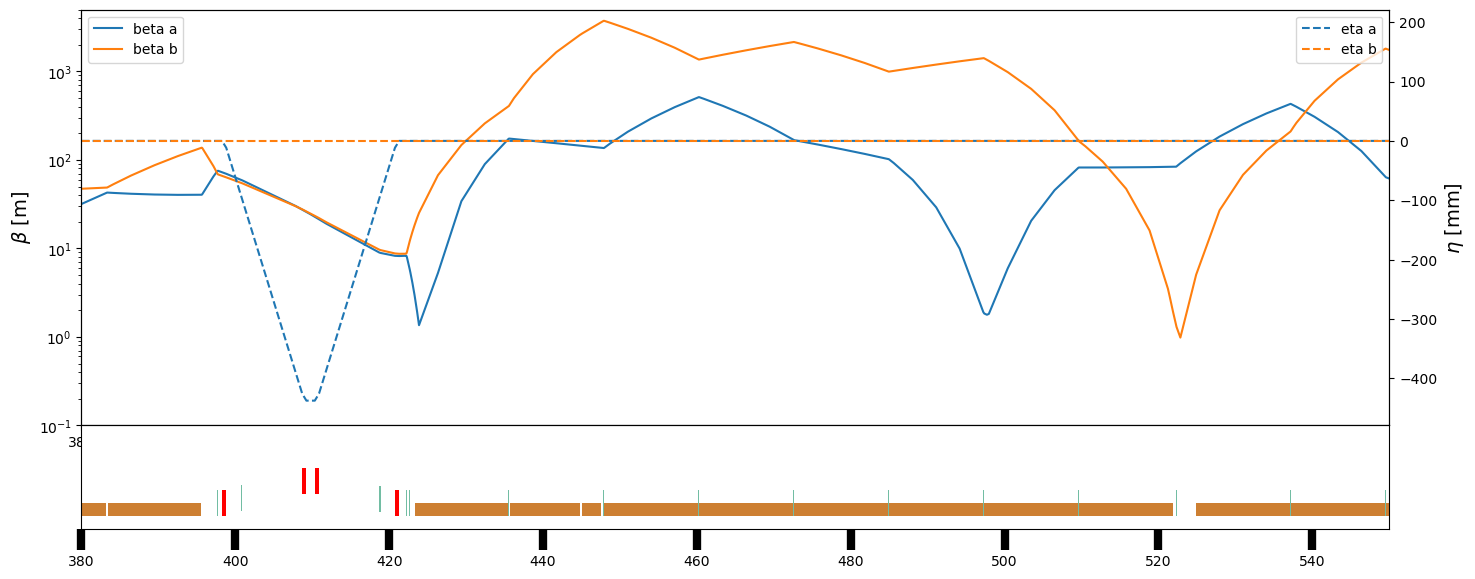

In [20]:
floorplanPlot(tao, zmin = 380, zmax = 550, ymin = 0.1, ymax = 5000)